In [1]:
import pandas as pd
import cobra
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import linprog
import scipy
import mip
from copy import deepcopy

def save_dict(data, name):
    with open(name, 'w' ) as file:
        json.dump( data, file )

# Community modeling

In this notebook we will implement a method to create community models of two or more species specific metabolic models using cobrapy.

In [2]:
model_DP = cobra.io.read_sbml_model("models/consistent_DP_SNM.xml")
model_SA = cobra.io.read_sbml_model("models/consistent_iYS854_SNM.xml")
print("Growth: ", model_DP.slim_optimize())
print("Growth: ", model_SA.slim_optimize())

Growth:  0.2823653925322476
Growth:  2.558694612613393


In [3]:
for rec in model_SA.reactions:
    rec.lower_bound = max(rec.lower_bound, -1000)
    rec.upper_bound = min(rec.upper_bound, 1000)

In [4]:
snm3 = pd.read_csv("SNM3.csv", sep =";")
snm3.head()

,Compound,BiGG,ModelSeed,KEGG
0,Alanine,ala__L,cpd00035,C00041
1,Arginine,arg__L,cpd00051,C00062
2,Cysteine,cys__L,cpd00084,C00097
3,Glutamic acid,glu__L,cpd00023,C00025
4,Glycine,gly,cpd00033,C00037


In [5]:
BIOMASS_DP = "Growth" 
BIOMASS_SA = "BIOMASS_iYS_wild_type"
models = [model_DP.copy(), model_SA.copy()]

The following metabolites have been previously added to obtain growth on the medium: EX_ile__L_e, EX_met__L_e and EX_26dap__M_e for DP. In the community this may is not necessary as the metabolites could be produced from e.g. SA.

**PROBLEM:** SA does not have EX_26dap__M_e and hence cannot produce it for DP....

Thus we cannot drop EX_26dap__M_e from the medium otherwise DP could not grow...

In [6]:
print(model_SA.exchanges.EX_met__L_e)
print(model_SA.exchanges.EX_ile__L_e)
#print(model_SA.exchanges.EX_26dap__M_e)

EX_met__L_e: met__L_e --> 
EX_ile__L_e: ile__L_e --> 


In [7]:
# Can produces met
with model_SA as model: 
    model.objective = model.exchanges.EX_met__L_e
    print(model.slim_optimize())

10.0


In [8]:
# Can produces ile
with model_SA as model: 
    model.objective = model.exchanges.EX_ile__L_e
    print(model.slim_optimize())

21.40625


In [9]:
model_SA.compartments

{'c': 'cytosol', 'w': 'wildtype staph aureus', 'e': 'extracellular space'}

## 1) Constructing of community model explicitely

Here we introduce only shuttle reactions for reactions that are common in the uptake/sekretion reactions of the individual models!

In [10]:
def create_stoichiometry_matrix(model):
    metabolites = model.metabolites 
    reactions = model.reactions 
    S = np.zeros((len(metabolites), len(reactions)))
    
    met_id = dict()
    rec_id = dict()
    for i,reaction in enumerate(model.reactions):
        rec_id[reaction.id] = i
        for metabolite, stoich in reaction.metabolites.items():
            met_id[metabolite.id] = int(metabolites.index(metabolite))
            S[metabolites.index(metabolite), i] = stoich
    return S, met_id, rec_id 

In [11]:
class Model():
    def __init__(self, model, biomass_function):
        """ This is a new class of metabolic model, capable of flux balance analysis
        Attributes:
        models (list): CobraPy models of single organisms which will be used in construction
        biomass_reactions (list): List of strings containing the ids for the growth reactions
        """
        self.biomass_function = biomass_function
        self.model = model
        self.id = model.id
        # Compute stoichimetry_matrix
        S, met_id, rec_id = create_stoichiometry_matrix(model)
        self.num_reactions = S.shape[1]
        self.num_metabolites = S.shape[0]
        self.stoichiometry_matrix = scipy.sparse.csr_matrix(S)
        self.met_id = met_id
        self.rec_id = rec_id 
        # Set objective
        idx = self.rec_id[biomass_function]
        c = np.zeros(self.num_reactions)
        c[idx] = 1
        self.objective_c = c
        # Set bounds
        self._reset_bounds()
    
    @property
    def reactions(self):
        return self.model.reactions
    @property
    def exchanges(self):
        return self.model.exchanges
    @property
    def metabolites(self):
        return self.model.metabolites
    @property
    def medium(self):
        return self.model.medium

    def set_medium(self, medium):
        ex_ids = [ex.id for ex in self.exchanges]
        new_med = {}
        for key,val in medium.items():
            if key in ex_ids:
                new_med[key] = val
        self.model.medium = new_med
        self._reset_bounds()
        
    def optimize(self, disp=False):
        sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
        sol["fun"] = -sol["fun"] # As we have to minimize
        return sol 
    
    def slim_optimize(self, disp=False):
        sol = self.optimize(disp=disp)
        return sol["fun"]

    def summary(self):
        sol = self.optimize()
        flux = sol["x"]
        ex_ids = [ex.id for ex in self.exchanges]
        fluxes = []
        for ex in ex_ids:
            idx = self.rec_id[ex]
            fluxes.append(flux[idx])
        summary_df = pd.DataFrame({"Exchange reaction": ex_ids, "Flux": fluxes})
        summary_df.sort_values(["Flux"], inplace=True)
        return summary_df

    def _reset_bounds(self):
        self.bounds = []
        for rec in self.model.reactions:
            self.bounds.append((rec.lower_bound, rec.upper_bound))

    def __add__(self, model2):
        """ Adding another model creates a community model """
        return CommunityModel([self,model2], [1.,1.])
    

In [12]:
model1 = Model(model_DP, BIOMASS_DP)
model2 = Model(model_SA, BIOMASS_SA)

$$ \max \sum_{i=1}^n \theta_i \text{ subject to }$$

$$ SV = 0, V_{j,min} \leq V_j \leq V_{j, max}, V_{Growth} \geq MBR/10 , V_{i, COOPM} + V_{i, min}\theta_i \geq V_{i,\min} $$

In [13]:
from mip import Model, xsum, maximize, BINARY

S1 = model1.stoichiometry_matrix.todense()
S1_dict = model1.rec_id 
bounds1 = model1.bounds 
obj1 = np.where(model1.objective_c > 0)[0][0]

S2 = model2.stoichiometry_matrix.todense()
S2_dict = model2.rec_id 
bounds2 = model2.bounds
obj2 = np.where(model2.objective_c > 0)[0][0]

In [14]:
snm3_med = dict(list(model_DP.medium.items()) + list(model_SA.medium.items()))

We will add following constraints:
* All EX_ile__L_e used by DP must be produced by SA.
* All EX_met__L_E used by DP must be produced by SA.

In [15]:
from mip import Model, xsum, maximize, BINARY

comm_model = Model("COOPM")

# Shuttel reactions
x_sh = []
id1 = []
id2 = []
x_sh_dict = {}
for key, val in snm3_med.items():
    x = comm_model.add_var(lb=-val, ub=1000)
    x_sh +=[x]
    x_sh_dict[key] = x
    if key in S1_dict:
        id1 += [S1_dict[key]]
    else:
        id1 += [None]
    if key in S2_dict:
        id2 += [S2_dict[key]]
    else:
        id2 += [None]

# Flux first model
x1 = []
for i, (lb, ub) in enumerate(bounds1): 
    x1 += [comm_model.add_var(lb = lb, ub=ub)]

# Flux second model
x2 = []
for i, (lb, ub) in enumerate(bounds2): 
    x2 += [comm_model.add_var(lb = lb, ub=ub)]
# Stoichiometry
for i in range(S1.shape[0]):
    comm_model.add_constr(xsum(S1[i,j]*x1[j] for j in range(S1.shape[1])) == 0)

for i in range(S2.shape[0]):
    comm_model.add_constr(xsum(S2[i,j]*x2[j] for j in range(S2.shape[1])) == 0)

ids_ile = (0,0)
ids_met = (0,0)
# Shuttel constraints
for i,key in enumerate(snm3_med):
    if "EX_ile__L_e" == key:
        idx1 = id1[i]
        idx2 = id2[i]
        ids_ile = (idx1, idx2)
        
        # Sa must produce it...
        comm_model.add_constr(x1[idx1] + x2[idx2] == 0)
    elif "EX_met__L_e" == key:
        idx1 = id1[i]
        idx2 = id2[i]
        ids_met = (idx1, idx2)
        # Sa must produce it
        comm_model.add_constr(x1[idx1] + x2[idx2] == 0)
    if id1[i] is not None and id2[i] is not None:
        idx1 = id1[i]
        idx2 = id2[i]
        comm_model.add_constr(-x_sh[i] + x1[idx1] + x2[idx2] == 0)
    elif id1[i] is not None:
        idx = id1[i]
        comm_model.add_constr(-x_sh[i] + x1[idx] == 0)
    else:
        idx = id2[i]
        comm_model.add_constr(-x_sh[i] + x2[idx] == 0)



In [16]:
def get_exchange_flux(S_dict, x):
    dic ={}
    for key, val in S_dict.items():
        if "EX_" in key:
            dic[key] = x[val].x
    return dic

def get_medium(x):
    dic = {}
    for key, val in x.items():
        dic[key] = val.lb
    return dic

First looking at the convex combinaiton

In [17]:
comm_model.objective = maximize(x1[obj1] + x2[obj2])
comm_model.optimize()
print(x2[obj2].x)
print(x1[obj1].x)

2.5586946126135386
0.0


In [18]:
alphas = np.linspace(0,1,1000)
DP_growth = []
SA_growth = []
for a in alphas:
    comm_model.objective = maximize(a*x1[obj1] + (1-a)*x2[obj2])
    comm_model.optimize()
    DP_growth.append(x1[obj1].x)
    SA_growth.append(x2[obj2].x)

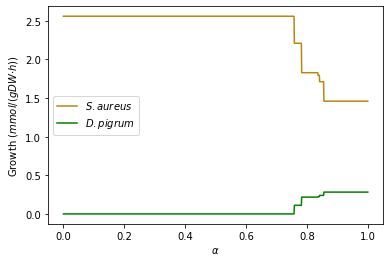

In [19]:
title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal'} 
plt.plot(alphas, SA_growth, 'darkgoldenrod')
plt.plot(alphas, DP_growth, 'g')
plt.legend(["$\it{S.aureus}$" , "$\it{D. pigrum}$"])
plt.xlabel(r'$\alpha$')
plt.ylabel("Growth $(\it{mmol/(gDW⋅h)})$")
plt.savefig("DP_noGrowth_SNM.pdf", bbox_inches='tight', dpi=1000)  
plt.show()

In [103]:
# SA dominates
w1 = 0.78
w2 = 0.22

comm_model.objective = maximize(w1*x1[obj1] + w2*x2[obj2])
comm_model.optimize()
print(x1[obj1].x)
print(x2[obj2].x)
minMBR = (w1*x1[obj1].x + w2*x2[obj2].x)/10
print(minMBR)

0.11154453877419865
2.209050228492479
0.05729957905122203


In [104]:
# SA dominates
w1 = 0.85
w2 = 0.15

comm_model.objective = maximize(w1*x1[obj1] + w2*x2[obj2])
comm_model.optimize()
print(x1[obj1].x)
print(x2[obj2].x)
minMBR = (w1*x1[obj1].x + w2*x2[obj2].x)/10
print(minMBR)

0.23964769396777452
1.7115657973987406
0.04604354094824194


In [105]:
comm_model.objective = maximize(x1[obj1])
comm_model.optimize()
x1[obj1].x

0.2823653925321281

In [106]:
print("DP flux:", x1[S1_dict["EX_ile__L_e"]].x)
print("SA flux:", x2[S2_dict["EX_ile__L_e"]].x)
print("DP flux:", x1[S1_dict["EX_met__L_e"]].x)
print("SA flux:", x2[S2_dict["EX_met__L_e"]].x)

DP flux: -0.07944457706688934
SA flux: 0.07944457706688934
DP flux: -0.042086109860927944
SA flux: 0.042086109860927944


In [107]:
interchange = {"DP_flux":[], "SA_flux":[]}
index = list()
for key, val in get_exchange_flux(S1_dict,x1).items():
    other_echange = get_exchange_flux(S2_dict,x2)
    if val < 0 and abs(val) > 1e-4:
        print(key, val)
        index += [key]
        if key in other_echange:
            print("Other exchange",key, other_echange[key])

EX_glc__D_e -10.0
Other exchange EX_glc__D_e 0.0
EX_leu__L_e -0.1231968056562889
Other exchange EX_leu__L_e 0.0
EX_4abz_e -0.0001829367191398964
EX_ala__L_e -0.6181950007092877
EX_cl_e -0.016592706807376918
Other exchange EX_cl_e 0.0
EX_pi_e -0.2413552445853983
Other exchange EX_pi_e -0.7863189048700191
EX_ribflv_e -0.0001219578127203424
Other exchange EX_ribflv_e 5.43082061294064e-16
EX_gly_e -0.9992216622720426
EX_thr__L_e -0.06937020546094937
EX_arg__L_e -0.0808837339465763
Other exchange EX_arg__L_e 9.399951198262272
EX_lys__L_e -0.093836692759916
Other exchange EX_lys__L_e -0.3931594524375338
EX_k_e -0.015045698519933964
Other exchange EX_k_e 0.0
EX_pro__L_e -0.060447049979581786
EX_ca2_e -0.014677908938618027
EX_mg2_e -0.02420330114963725
Other exchange EX_mg2_e 0.0
EX_mn2_e -0.010707719788919568
Other exchange EX_mn2_e 0.0
EX_cobalt2_e -0.009981830860057387
EX_zn2_e -0.008993582449539567
Other exchange EX_zn2_e 0.0
EX_cu2_e -0.009257250408238668
EX_o2_e -0.12577861281033526
Othe

In [108]:
ids_ile

(1055, 335)

In [109]:
def fix_ile_growth(value):
    x1[ids_ile[0]].ub = value + 1e-4
    x1[ids_ile[0]].lb = value
    comm_model.optimize()
    x1[ids_ile[0]].ub = 1000
    x1[ids_ile[0]].lb = -10
    return x1[obj1].x, x2[obj2].x
def fix_met_growth(value):
    x1[ids_met[0]].ub = value + 1e-4
    x1[ids_met[0]].lb = value
    comm_model.optimize() 
    x1[ids_met[0]].ub = 1000
    x1[ids_met[0]].lb = -10
    return x1[obj1].x, x2[obj2].x

In [110]:
comm_model.objective = maximize(w1*x1[obj1] + w2*x2[obj2])
print(comm_model.optimize())
print(x1[obj1].x)
print(x2[obj2].x)

OptimizationStatus.OPTIMAL
0.23964769396773955
1.7115657973986667


In [111]:
print("DP flux:", x1[ids_ile[0]].x)
print("SA flux:", x2[ids_ile[1]].x)
print("DP flux:", x1[ids_met[0]].x)
print("SA flux:", x2[ids_met[1]].x)

DP flux: -0.06742579011403184
SA flux: 0.06742579011403184
DP flux: -0.03571910525507029
SA flux: 0.03571910525507029


In [112]:
flux = np.linspace(-10,0) 
growths_DP = []
growths_SA = []
for f in flux:
    growth_DP, growth_SA = fix_ile_growth(f)
    if growth_DP is None:
        growths_DP.append(0)
        growths_SA.append(0)
    else:
        growths_DP.append(growth_DP)
        growths_SA.append(growth_SA)

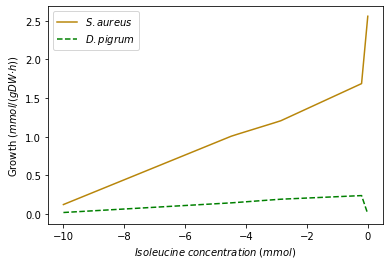

In [113]:
plt.plot(flux, growths_SA, 'darkgoldenrod')
plt.plot(flux, growths_DP, 'g--')
plt.legend(["$\it{S.aureus}$" , "$\it{D. pigrum}$"])
plt.xlabel("$ Isoleucine\; concentration\;(\it{mmol})$") 
plt.ylabel("Growth $(\it{mmol/(gDW⋅h)})$")
#plt.title("Ile fixed flux growth")
plt.savefig("ile_fixed_flux_growth_DP_nogrowth.pdf")

In [114]:
flux = np.linspace(-0.1,0) 
growths_DP = []
growths_SA = []
for f in flux:
    growth_DP, growth_SA = fix_met_growth(f)
    if growth_DP is None:
        growths_DP.append(0)
        growths_SA.append(0)
    else:
        growths_DP.append(growth_DP)
        growths_SA.append(growth_SA)

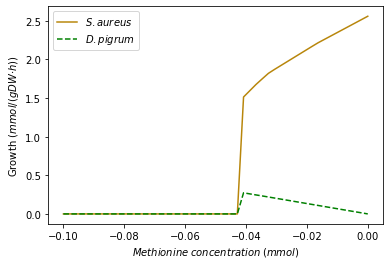

In [115]:
plt.plot(flux, growths_SA, 'darkgoldenrod')
plt.plot(flux, growths_DP, 'g--')
plt.legend(["$\it{S.aureus}$" , "$\it{D. pigrum}$"])
plt.xlabel("$Methionine\; concentration\;(\it{mmol})$") 
plt.ylabel("Growth $(\it{mmol/(gDW⋅h)})$")
#plt.title("Ile fixed flux growth")
plt.savefig("met_fixed_flux_growth_DP_nogrowth.pdf")